In [55]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

 展平每图像，将它们视为长度为784的向量。因为我们的数据集有10个类别，所以网络输出维度为10

In [75]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

给定一个矩阵x,对所有元素求和 

In [57]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True),X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax

In [58]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里应用了广播机制

我们将每个元素变成一个非负数。此外，一句概率原理，每行总和为

In [59]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1254, 0.1710, 0.0263, 0.0926, 0.5848],
         [0.1926, 0.3333, 0.0748, 0.2006, 0.1986]]),
 tensor([1.0000, 1.0000]))

实现softmax回归模型

In [86]:
def net(x):
    return softmax(torch.matmul(x.reshape(-1, W.shape[0]),W) +b )

创建一个数据y_hat,其中包含2个样本在3个类别的预测概率，使用y作为y_hat中概率的索引


In [87]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0,1],y] # 从第0个样本中拿出第一个值，从第1个样本中拿出第二个值

tensor([0.1000, 0.5000])

实现交叉熵损失函数

In [88]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y]) 
"""
交叉熵除了真值是1，其他的值都是0，因此-y*logyi=-logyi,yi是去真实值1的预测概率
"""
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

将预测类别与真实y元素进行比较

In [89]:
def accuracy(y_hat, y):
    """
    计算预测正确的数量
    """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis =1) # 返回每一行最大元素对应的列下标
    cmp = y_hat.type(y.dtype)  == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

我们可以评估在任意模型net的准确率


In [64]:
def evaluation_accuracy(net, data_iter):
    """
    计算在指定数据集上的模型的精度
    """
    if isinstance(net, torch.nn.Module):
        net.eval()   # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数，预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

Accumulator实例中创建2个变量，用于分别存储正确预测的数量和预测的总数量
    

In [90]:
class Accumulator:
    """
    在n个变量上累加
    """
    def __init__(self,n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b  in zip(self.data,args)]
    def reset(self):
        self.data  = [0.0] * len(self.data)
    def __getitem__(self,idx):
        return self.data[idx]
    
evaluation_accuracy(net, test_iter)

0.118

softmax回归的训练

In [100]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.step()
            metric.add(
                float(l) * len(y),accuracy(y_hat, y),
                y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y),y.numel())
    return metric[0] / metric[2], metric[1]/metric[2]

训练函数

In [104]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluation_accuracy(net,test_iter)
    train_loss, train_acc = train_metrics

小批量随机梯度下降来优化模型的损失函数

In [105]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

训练模型10个迭代周期

In [106]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

对图像进行分类预测

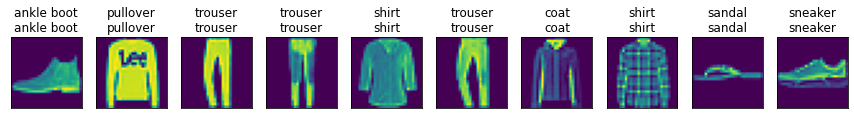

In [113]:
def predict_ch3(net, test_iter, n=10):
    """
    预测标签
    """
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true ,pred in zip(trues,preds)]
    d2l.show_images(X[0:n].reshape((n,28,28)),1,n,titles=titles[0:n])
    
predict_ch3(net, test_iter)